In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/research/ICML-2020/clustering') 
os.listdir(os.getcwd())

['Explaining_Decision_of_Time_Series_Data',
 'model',
 'data',
 'savedmodel',
 'model-clustering.ipynb',
 'model_kmeans.ipynb']

In [3]:
import time

import numpy as np
from numpy import dstack

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from tensorflow.python.ops import nn_ops, gen_nn_ops

import tensorflow as tf

import matplotlib.pyplot as plt 

# CNN model

In [0]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob,is_dropout):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return relu3
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

# For HAR dataset

Data Load - 전처리 width, height, input_channel 정의

In [0]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial-Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [6]:
data_path ="./data/HAR/"

# load all train
trainx, trainy = load_dataset('train', data_path)
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))

print(trainx.shape, trainy.shape)
# load all test
testx, testy = load_dataset('test', data_path)
print(testx.shape, testy.shape)

batch size:16
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [7]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (7352, 6)
y test shape: (2947, 6)


In [8]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train
validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]
testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]
print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(7352, 1, 128, 9)
trainY shape:(7352, 6)
validX shape:(1473, 1, 128, 9)
validY shape:(1473, 6)
testX shape:(1474, 1, 128, 9)
testY shape:(1474, 6)


In [9]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]
print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 128
input_channel 9


Training condition 정의

In [0]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

 model structure 정의

In [11]:
nb_classes =trainY.shape[1]
print (nb_classes)

6


In [12]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.


In [13]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)
print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 128, 9), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 128, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 128, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128),

Training

In [14]:
save_path = './savedmodel'
model_name = 'ICML(UCR-HAR)_CNN_MCdropout_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(UCR-HAR)_CNN_MCdropout_1e-05_16


In [0]:
def get_batch(X, Y,  batch_size=1024, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [0]:
keep_prob =1.0

In [0]:
# for epoch in range(num_epochs):#range(num_epochs):##
    
#     loss = 0
#     acc=0
#     train_batches = 0
#     start_time = time.time()   
    
#     for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
#         train_in, train_target = batch
#         train_batches += 1.0 
#         loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
#         loss = loss1+loss
#         acc = acc1+acc
#         if np.isnan(loss):
#             print ('error')
#             break
#     t_loss.append(loss/train_batches)
#     t_acc.append(acc/train_batches)
    
#     train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
#     if not os.path.exists(os.path.join(save_path, model_name)):
#         os.mkdir( os.path.join(save_path, model_name))
#     MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
#     if(epoch+1)%val_freq ==0:
#         acc=0
#         loss = 0
#         val_batches=0
#         for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
#             val_in, val_target = batch
#             val_batches += 1.0 
#             loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
#             loss = loss1+loss
#             acc = acc1+acc
        
#         v_acc.append(acc/val_batches)
#         v_loss.append(loss/val_batches)
#         valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
#         print("  training loss:\t{:.6f}".format(t_loss[epoch]))
#         print("  training acc:\t{:.3f}".format(t_acc[epoch]))
#         print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
#         print("  validation acc:\t{:.3f}".format(v_acc[epoch]))

In [0]:
# train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
# valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

### Check result
with loss and accuracy graph

In [0]:
save_path = './model/'

In [0]:
# train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
# valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)
train_history = pd.read_csv(os.path.join(save_path, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, "history_valid.csv"),index_col=0)

Text(0, 0.5, 'acc')

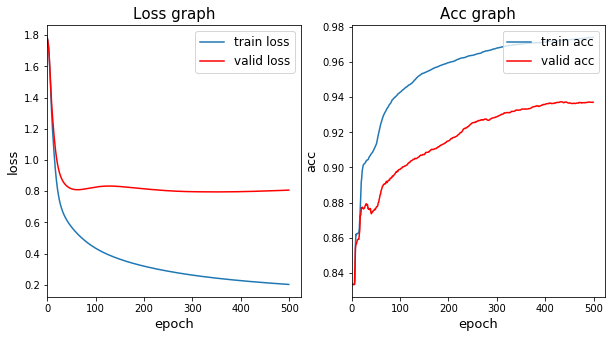

In [21]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

# plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)

# plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))

In [22]:
bestepoch = int(np.argmin(valid_history['loss']))
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))
bestepoch=bestepoch
# MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))
MC_dropout_model.load(os.path.join(save_path, str(bestepoch)+'.ckpt'))

error: 0.7950858847238835
INFO:tensorflow:Restoring parameters from ./model/346.ckpt


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Model restored


with confusion matrix

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

In [0]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

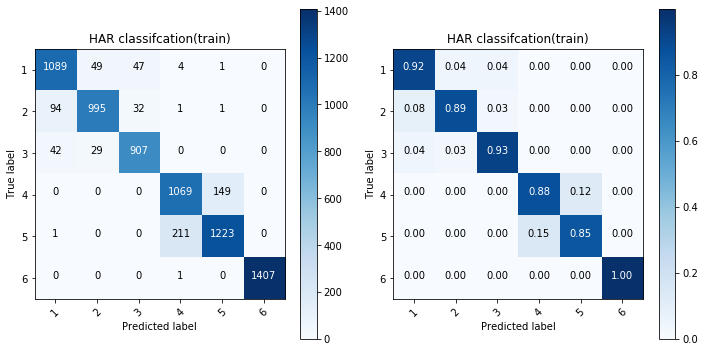

In [25]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR classifcation(train)')

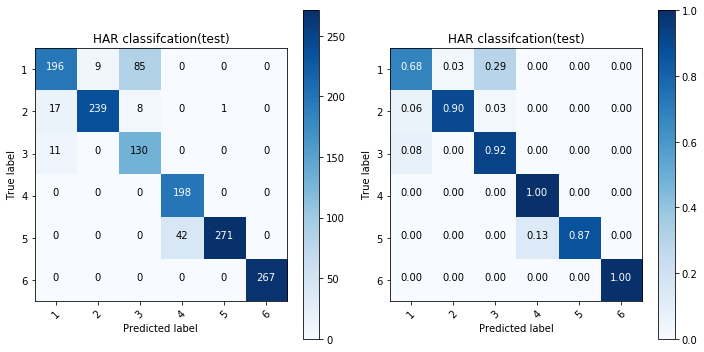

In [26]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR classifcation(test)')

### Last Conv output Load

In [0]:
import random

In [28]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
last_conv_output.shape
threshold = np.percentile(last_conv_output,99.5)
print ("threshold: {}".format(threshold))

threshold: 5.451408386230469


In [29]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_bool = last_conv_output>threshold
print (last_conv_bool.shape)

(7352, 128, 128)


### Result visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

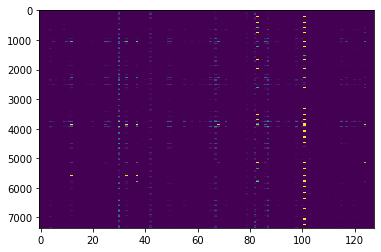

In [30]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

패턴의 연속성

In [0]:
from pylab import rcParams
# rcParams['figure.figsize'] = 20, 12
from itertools import groupby
from operator import itemgetter

In [32]:
consecutive_num =trainX.shape[2]//20
consecutive_num

6

### pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)

In [33]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g,c]})

pattern_candidate = [x['pattern'] for x in consecutive_pattern]
len(pattern_candidate)

7128

패턴 길이

In [0]:
l_pattern=[]
for l in np.unique([len(x) for x in pattern_candidate]):
    l_pattern.append(len([x for x in pattern_candidate if len(x)==l]))

In [0]:
l_pattern_dict=dict() # l_pattern_dict :패턴의 길이와 해당 길이의 패턴의 수를 매칭시켜놓은 변수
for i,l in enumerate(l_pattern):
    l_pattern_dict[str(np.unique([len(x) for x in pattern_candidate])[i])]=l

In [36]:
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==128]) # 6, 7, 8, 128, 9, ...
len(l_pattern_candidate)

765

## clustering for pattern_candidate
consecutive_pattern: (data_idx, pattern_idx, pattern) dictionary 형태. 여기서 pattern만 모아 pattern_candidate에 저장. pattern_candidate을 클러스터링
### K-means

In [39]:
# !pip install tslearn

     |████████████████████████████████| 532kB 5.0MB/s 
  Created wheel for tslearn: filename=tslearn-0.2.5-cp36-cp36m-linux_x86_64.whl size=816790 sha256=b500b14463d56add45b744a1ef926919fba9065253f517a89d98ebb39c7c5fb0
  Stored in directory: /root/.cache/pip/wheels/1d/6a/f7/145f874cbaebf801a5d89b71197585db9b1ddc72d666236cc3
Successfully built tslearn


In [0]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

(1719, 6, 1)
1.683 --> 1.284 --> 1.226 --> 1.208 --> 1.205 --> 1.205 --> 1.204 --> 1.203 --> 1.203 --> 1.203 --> 


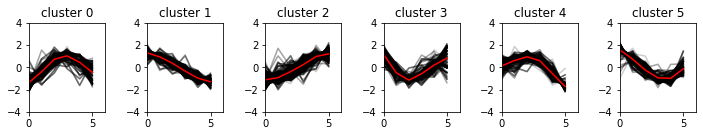

In [41]:
# 6
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==6]) # 6, 7, 8, 128, 9, ...
l_pattern_candidate = l_pattern_candidate.reshape(l_pattern_candidate.shape[0], l_pattern_candidate.shape[1], 1)
print(l_pattern_candidate.shape)

seed = 0
np.random.seed(seed)
signals = TimeSeriesScalerMeanVariance().fit_transform(l_pattern_candidate)
sz = signals.shape[1]
# Euclidean k-means
n_clusters = 6
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(signals)
rcParams['figure.figsize'] = 10, 5
plt.figure()
for y in range(n_clusters):
    plt.subplot(3, n_clusters, y + 1)
    for x in signals[y_pred == y]:
        plt.plot(x.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[y].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)    
    plt.title("cluster %d" % y)

plt.tight_layout()
plt.show()

(1161, 7, 1)
2.314 --> 1.698 --> 1.679 --> 1.670 --> 1.665 --> 1.658 --> 1.654 --> 1.653 --> 1.653 --> 1.653 --> 


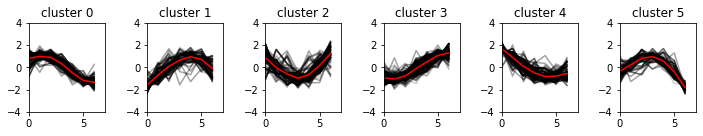

In [42]:
# 7
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==7]) # 6, 7, 8, 128, 9, ...
l_pattern_candidate = l_pattern_candidate.reshape(l_pattern_candidate.shape[0], l_pattern_candidate.shape[1], 1)
print(l_pattern_candidate.shape)

seed = 0
np.random.seed(seed)
signals = TimeSeriesScalerMeanVariance().fit_transform(l_pattern_candidate)
sz = signals.shape[1]
# Euclidean k-means
n_clusters = 6
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(signals)
rcParams['figure.figsize'] = 10, 5
plt.figure()
for y in range(n_clusters):
    plt.subplot(3, n_clusters, y + 1)
    for x in signals[y_pred == y]:
        plt.plot(x.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[y].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)    
    plt.title("cluster %d" % y)

plt.tight_layout()
plt.show()

(909, 8, 1)
3.268 --> 2.447 --> 2.380 --> 2.346 --> 2.332 --> 2.325 --> 2.318 --> 2.309 --> 2.300 --> 2.283 --> 2.262 --> 2.254 --> 2.250 --> 2.247 --> 2.245 --> 2.245 --> 


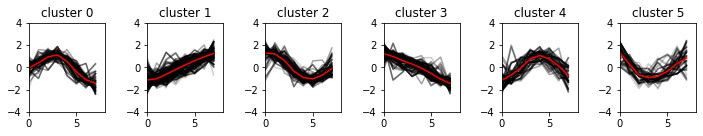

In [43]:
# 8
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==8]) # 6, 7, 8, 128, 9, ...
l_pattern_candidate = l_pattern_candidate.reshape(l_pattern_candidate.shape[0], l_pattern_candidate.shape[1], 1)
print(l_pattern_candidate.shape)

seed = 0
np.random.seed(seed)
signals = TimeSeriesScalerMeanVariance().fit_transform(l_pattern_candidate)
sz = signals.shape[1]
# Euclidean k-means
n_clusters = 6
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(signals)
rcParams['figure.figsize'] = 10, 5
plt.figure()
for y in range(n_clusters):
    plt.subplot(3, n_clusters, y + 1)
    for x in signals[y_pred == y]:
        plt.plot(x.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[y].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)    
    plt.title("cluster %d" % y)

plt.tight_layout()
plt.show()

(765, 128, 1)
184.575 --> 106.282 --> 104.590 --> 103.917 --> 103.540 --> 103.321 --> 103.089 --> 102.922 --> 102.860 --> 102.809 --> 102.741 --> 102.705 --> 102.683 --> 102.657 --> 102.634 --> 102.616 --> 102.597 --> 102.583 --> 102.574 --> 102.574 --> 


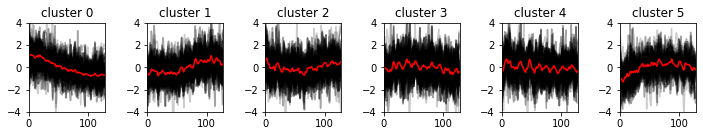

In [44]:
# 128
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==128]) # 6, 7, 8, 128, 9, ...
l_pattern_candidate = l_pattern_candidate.reshape(l_pattern_candidate.shape[0], l_pattern_candidate.shape[1], 1)
print(l_pattern_candidate.shape)

seed = 0
np.random.seed(seed)
signals = TimeSeriesScalerMeanVariance().fit_transform(l_pattern_candidate)
sz = signals.shape[1]
# Euclidean k-means
n_clusters = 6
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(signals)
rcParams['figure.figsize'] = 10, 5
plt.figure()
for y in range(n_clusters):
    plt.subplot(3, n_clusters, y + 1)
    for x in signals[y_pred == y]:
        plt.plot(x.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[y].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)    
    plt.title("cluster %d" % y)

plt.tight_layout()
plt.show()

# For EEG noonTaeng2 dataset

Data Load - 전처리 width, height, input_channel 정의

In [0]:
from scipy.io import arff
import pandas as pd
from sklearn.model_selection import train_test_split

In [46]:
data = arff.loadarff('./data/EEG-Eye-State-Dataset.arff')
df = pd.DataFrame(data[0]).values
X, y = df[:, 0:14], df[:,-1]

reshapedX = []
reshapedY = []
for i in range(len(X)):
  if i < len(X)-117:
    reshapedX.append(X[i:i+117, :])
    reshapedY.append(y[i+116])

reshapedX = np.array(reshapedX, dtype=np.float64)
reshapedY = np.array(reshapedY, dtype=np.int64)
reshapedY = reshapedY.reshape(reshapedY.shape[0],1)
print(reshapedX.shape, reshapedY.shape)

(14863, 117, 14) (14863, 1)


In [47]:
trainx, testx, trainy, testy = train_test_split(reshapedX, reshapedY, test_size=0.33, random_state=321)
batch_size = min(int(trainx.shape[0]/10), 16)
print ("batch size:{}".format(batch_size))
print(trainx.shape, trainy.shape)
print(testx.shape, testy.shape)

batch size:16
(9958, 117, 14) (9958, 1)
(4905, 117, 14) (4905, 1)


In [48]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (9958, 2)
y test shape: (4905, 2)


In [49]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train
validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]
testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]
print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(9958, 1, 117, 14)
trainY shape:(9958, 2)
validX shape:(2452, 1, 117, 14)
validY shape:(2452, 2)
testX shape:(2453, 1, 117, 14)
testY shape:(2453, 2)


In [50]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]
print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 117
input_channel 14


Training condition 정의

In [0]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 50


std= 0.01
l_rate = 1e-5

train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

model structure 정의

In [52]:
nb_classes =trainY.shape[1]
print (nb_classes)

2


In [0]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [60]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)
print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 117, 14), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 117, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 117, 256), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 117, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 117, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 117, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128)

Training

In [61]:
save_path = './savedmodel'
model_name = 'ICML(EEG)_CNN_MCdropout_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(EEG)_CNN_MCdropout_1e-05_16


In [0]:
keep_prob =1.0

In [63]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))

INFO:tensorflow:./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/1.ckpt
  training loss:	6.712719
  training acc:	0.580
  validation loss:	0.810845
  validation acc:	0.563
INFO:tensorflow:./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/2.ckpt
  training loss:	0.669480
  training acc:	0.604
  validation loss:	0.657152
  validation acc:	0.600
INFO:tensorflow:./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/3.ckpt
  training loss:	0.668885
  training acc:	0.606
  validation loss:	0.632594
  validation acc:	0.601
INFO:tensorflow:./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/4.ckpt is not in all_model_checkpoi

In [0]:
train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

### Check result
with loss and accuracy graph

In [0]:
save_path = './savedmodel/'

In [0]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

Text(0, 0.5, 'acc')

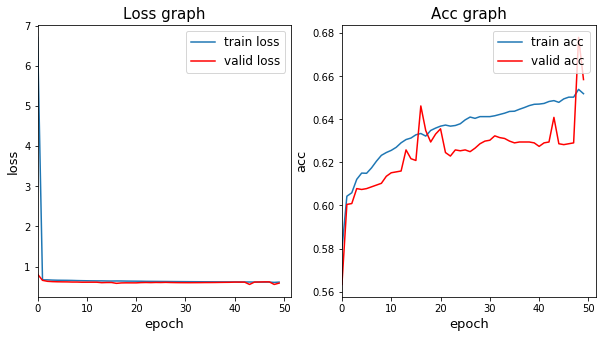

In [67]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

# plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)

# plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))

In [68]:
bestepoch = int(np.argmin(valid_history['loss']))
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

error: 0.5546215836908303
INFO:tensorflow:Restoring parameters from ./savedmodel/ICML(EEG)_CNN_MCdropout_1e-05_16/43.ckpt
Model restored


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


with confusion matrix

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

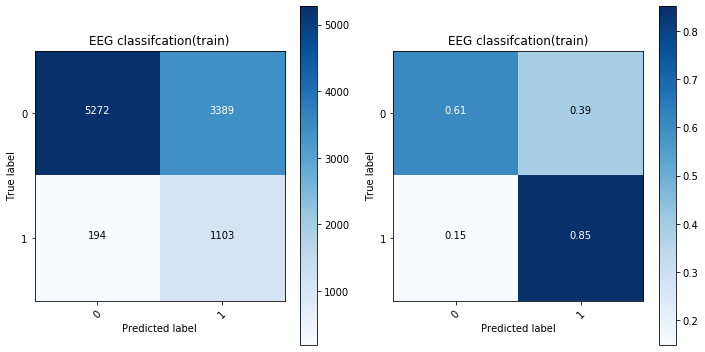

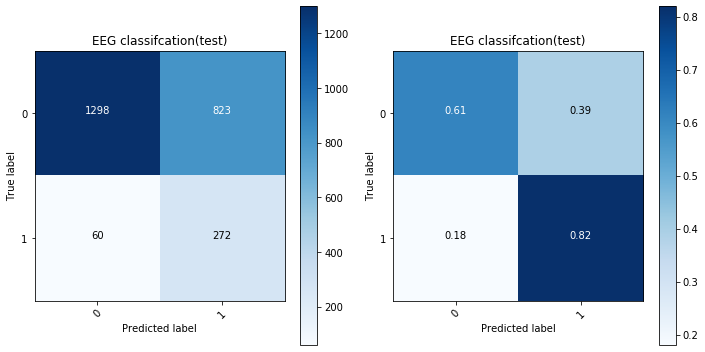

In [70]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='EEG classifcation(train)')

prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='EEG classifcation(test)')

### Last Conv output Load

In [0]:
import random

In [72]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
last_conv_output.shape
threshold = np.percentile(last_conv_output,99.5)
print ("threshold: {}".format(threshold))

threshold: 185.5256805419922


In [73]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_bool = last_conv_output>threshold
print (last_conv_bool.shape)

(9958, 117, 128)


### Result visualization
세로축(데이터) , 가로축(마지막 컨볼루션 채널) : 데이터와 별개로 각 채널마다 일관성있게 threshold를 넘은 구간이 존재함

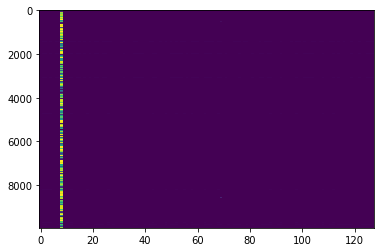

In [74]:
plt.imshow(last_conv_bool.sum(axis=1),aspect ="auto")

패턴의 연속성

In [0]:
from pylab import rcParams
from itertools import groupby
from operator import itemgetter

In [76]:
consecutive_num =trainX.shape[2]//20
consecutive_num

5

### pattern candidate 추출(전체길이의 10퍼센트 이상이 highlight 된 부분)

In [77]:
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]

consecutive_pattern=[]
for data_idx,data in enumerate(trainX[:500]):
    for output_channel_idx in survived_channel:
        pattern_bool =pd.DataFrame(last_conv_bool[data_idx][:,output_channel_idx])
        pattern_idx = [p for p, x in enumerate(last_conv_bool[data_idx][:,output_channel_idx]) if x]
        if pattern_idx:
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=itertools.count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
            for g in groups:
                if len(g)>=consecutive_num:
                    for c in range(0,data.shape[2]):
                        consecutive_pattern.append({"data_idx":data_idx, "pattern_idx":g, "pattern":data[0,g,c]})

pattern_candidate = [x['pattern'] for x in consecutive_pattern]
len(pattern_candidate)

20482

패턴 길이

In [0]:
l_pattern=[]
for l in np.unique([len(x) for x in pattern_candidate]):
    l_pattern.append(len([x for x in pattern_candidate if len(x)==l]))

l_pattern_dict=dict() # l_pattern_dict :패턴의 길이와 해당 길이의 패턴의 수를 매칭시켜놓은 변수
for i,l in enumerate(l_pattern):
    l_pattern_dict[str(np.unique([len(x) for x in pattern_candidate])[i])]=l

In [79]:
l_pattern_dict.keys()

dict_keys(['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '63', '64', '65', '66', '67', '68', '71', '72', '74', '76', '77', '79', '80', '82', '83', '84', '85', '86', '88', '91', '92', '94', '95', '96', '98', '99', '100', '110', '114', '117'])

In [80]:
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==5])
len(l_pattern_candidate)

2184

## clustering for pattern_candidate
consecutive_pattern: (data_idx, pattern_idx, pattern) dictionary 형태. 여기서 pattern만 모아 pattern_candidate에 저장. pattern_candidate을 클러스터링
### K-means

In [0]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

(2184, 5, 1)
6.294 --> 3.330 --> 3.218 --> 3.148 --> 3.111 --> 3.069 --> 3.042 --> 3.025 --> 3.014 --> 3.008 --> 3.002 --> 2.996 --> 2.994 --> 2.994 --> 2.994 --> 2.994 --> 


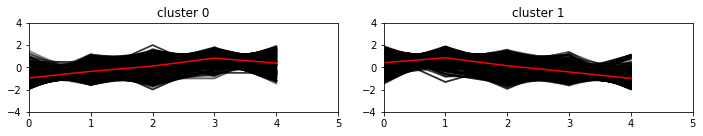

In [83]:
# 5
l_pattern_candidate = np.asarray([x for x in pattern_candidate if len(x)==5])
l_pattern_candidate = l_pattern_candidate.reshape(l_pattern_candidate.shape[0], l_pattern_candidate.shape[1], 1)
print(l_pattern_candidate.shape)

seed = 0
np.random.seed(seed)
signals = TimeSeriesScalerMeanVariance().fit_transform(l_pattern_candidate)
sz = signals.shape[1]
# Euclidean k-means
n_clusters = 2
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(signals)
rcParams['figure.figsize'] = 10, 5
plt.figure()
for y in range(n_clusters):
    plt.subplot(3, n_clusters, y + 1)
    for x in signals[y_pred == y]:
        plt.plot(x.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[y].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)    
    plt.title("cluster %d" % y)

plt.tight_layout()
plt.show()